## RL simulation analyses

In [1]:
import sys
import os
base_path = "/home/giuseppe/PNI/Bkup/Projects/RL_sim/"
sys.path.insert(0, base_path)
os.chdir(base_path)

from scipy.stats import t
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools

%matplotlib inline

In [2]:
parameters = {
    'snr': [0.5, 1, 2, 3, 5],
    'n_bins': [10],
    'kernel_size': [20],
    'kernel_sigma': [0.5, 1.0, 2.0, 3.0, 4.0],
    'learning_rate': [0.05, 0.1, 0.3, 0.4, 0.8, 0.9],
    'temperature': [0.2],
    'min_temperature': [1e-5],
    'max_temperature': [1.0],
    'reduce_temperature': [False],
    'decay_rate': [0.001]
}

# load data;
data = pd.read_pickle("./results/data.pkl")
print("Unique combinations of parameters", data.shape[0])

Unique combinations of parameters 1500000


## Summarize parameter search

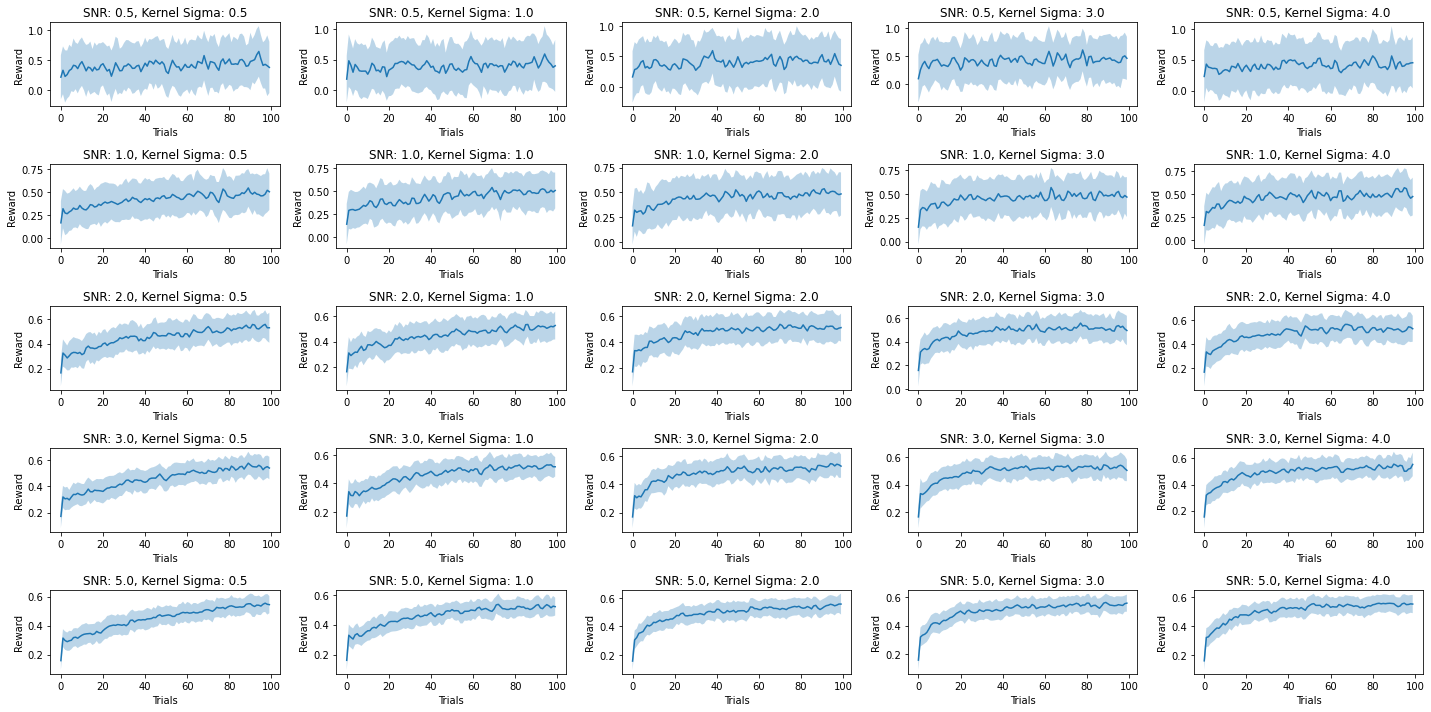

In [3]:
# set up variables;
unique_snr_values = data["snr"].unique()
unique_kernel_sigma_values = data["kernel_sigma"].unique()
unique_learning_rate_values = data["learning_rate"].unique()
unique_temperature_values = data["temperature"].unique()

# Generate combinations of snr and kernel_sigma
snr_kernel_combinations = list(itertools.product(
    unique_snr_values,
    unique_kernel_sigma_values
))

# Generate all combinations of snr, kernel_sigma, lr, and temp
lr_temp_combinations = list(itertools.product(
    unique_learning_rate_values,
    unique_temperature_values
))

num_rows = len(unique_snr_values)
num_cols = len(unique_kernel_sigma_values)
row_idx = 0
col_idx = 0

n_epochs = 100
epoch_length = list(range(0, n_epochs))
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 10))

# loop through all combinations;
for idx, (snr, kernel_sigma) in enumerate(snr_kernel_combinations):
    # vars to save trials data;
    trial_summary = []
    trial_ci = []
    trial_lr_summary = []

    # get data for current parameters;
    sub_data = data[(data['snr'] == snr) & (data['kernel_sigma'] == kernel_sigma)]

    # generate subplot data;
    for epoch in epoch_length:
        trial_data = sub_data[sub_data["epochs"] == epoch]
        trial_summary.append(np.mean(trial_data["reward"]))
        trial_lr_summary.append(np.mean(trial_data["learning_rate"]))

        # get only data with best learning_rate;
        best_learning_rate = trial_data.loc[trial_data["reward"].idxmax(), ["learning_rate"]]
        trial_data = trial_data[trial_data["learning_rate"] == best_learning_rate[0]]

        # calculate the 95% confidence interval for reward;
        confidence_interval = t.interval(0.95, len(trial_data["reward"]) - 1,
                                         loc=np.mean(trial_data["reward"]),
                                         scale=np.std(trial_data["reward"]) / np.sqrt(len(trial_data["reward"])))
        trial_ci.append((confidence_interval[1] - confidence_interval[0]) / 2)

    # apply median smoothing to trial_summary using a rolling window;
    window_size = 2
    smoothed_summary = np.convolve(trial_summary, np.ones(window_size)/window_size, mode='same')

    # Fig1. Plot performance with the smoothed line; 
    axs[row_idx, col_idx].plot(epoch_length, smoothed_summary, label='Smoothed Mean Reward')

    # Fill the 95% confidence interval
    lower_bound = np.array(smoothed_summary) - np.array(trial_ci)
    upper_bound = np.array(smoothed_summary) + np.array(trial_ci)
    axs[row_idx, col_idx].fill_between(epoch_length, lower_bound, upper_bound, alpha=0.3, label='95% Confidence Interval')

    axs[row_idx, col_idx].set_xlabel("Trials")
    axs[row_idx, col_idx].set_ylabel("Reward")
    axs[row_idx, col_idx].set_title(f"SNR: {snr}, Kernel Sigma: {kernel_sigma}")
    # axs[row_idx, col_idx].legend()

    # correctly index subplots
    col_idx += 1
    if col_idx == num_cols:
        row_idx += 1
        col_idx = 0

# adjust layout;
plt.tight_layout()
plt.show()

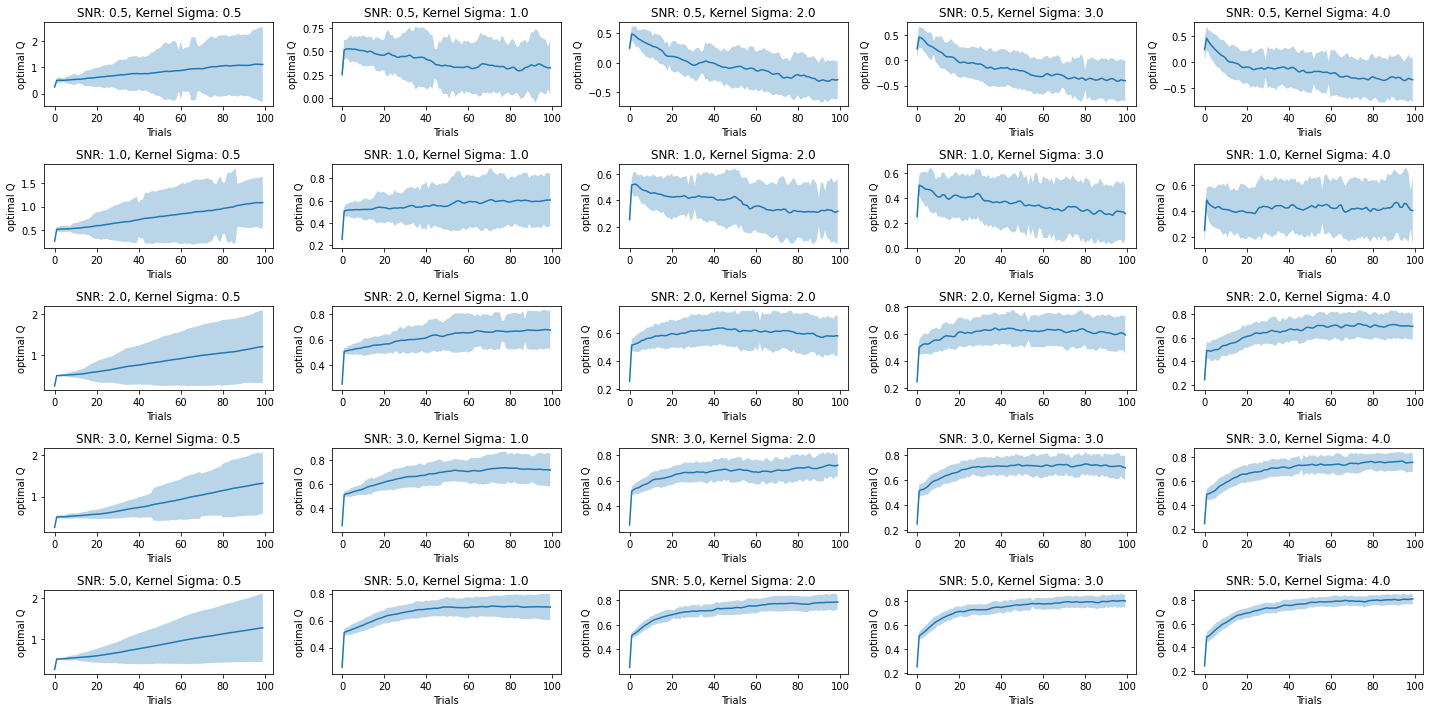

In [4]:
# set up variables;
unique_snr_values = data["snr"].unique()
unique_kernel_sigma_values = data["kernel_sigma"].unique()
unique_learning_rate_values = data["learning_rate"].unique()
unique_temperature_values = data["temperature"].unique()

# Generate combinations of snr and kernel_sigma
snr_kernel_combinations = list(itertools.product(
    unique_snr_values,
    unique_kernel_sigma_values
))

# Generate all combinations of snr, kernel_sigma, lr, and temp
lr_temp_combinations = list(itertools.product(
    unique_learning_rate_values,
    unique_temperature_values
))

num_rows = len(unique_snr_values)
num_cols = len(unique_kernel_sigma_values)
row_idx = 0
col_idx = 0

n_epochs = 100
epoch_length = list(range(0, n_epochs))
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 10))

# loop through all combinations;
for idx, (snr, kernel_sigma) in enumerate(snr_kernel_combinations):
    # vars to save trials data;
    trial_summary = []
    trial_ci = []
    trial_best_lr = []
    trial_best_temp = []

    # get data for current parameters;
    sub_data = data[(data['snr'] == snr) & (data['kernel_sigma'] == kernel_sigma)]

    # generate subplot data;
    for epoch in epoch_length:
        trial_data = sub_data[sub_data["epochs"] == epoch]
        trial_summary.append(np.mean(trial_data["optimum"]))

        # get only data with best learning_rate;
        best_learning_rate = trial_data.loc[trial_data["optimum"].idxmax(), ["learning_rate"]]
        trial_data = trial_data[trial_data["learning_rate"] == best_learning_rate[0]]

        # calculate the 95% confidence interval;
        confidence_interval = t.interval(0.95, len(trial_data["optimum"]) - 1,
                                         loc=np.mean(trial_data["optimum"]),
                                         scale=np.std(trial_data["optimum"]) / np.sqrt(len(trial_data["optimum"])))
        trial_ci.append((confidence_interval[1] - confidence_interval[0]) / 2)

    # Apply median smoothing to trial_summary using a rolling window
    window_size = 2
    smoothed_summary = np.convolve(trial_summary, np.ones(window_size)/window_size, mode='same')

    # Plot the smoothed line
    axs[row_idx, col_idx].plot(epoch_length, smoothed_summary, label='Smoothed Mean optimal Q-value')

    # Fill the 95% confidence interval
    lower_bound = np.array(smoothed_summary) - np.array(trial_ci)
    upper_bound = np.array(smoothed_summary) + np.array(trial_ci)
    axs[row_idx, col_idx].fill_between(epoch_length, lower_bound, upper_bound, alpha=0.3, label='95% Confidence Interval')

    axs[row_idx, col_idx].set_xlabel("Trials")
    axs[row_idx, col_idx].set_ylabel("optimal Q")
    axs[row_idx, col_idx].set_title(f"SNR: {snr}, Kernel Sigma: {kernel_sigma}")
    # axs[row_idx, col_idx].legend()

    # correctly index subplots
    col_idx += 1
    if col_idx == num_cols:
        row_idx += 1
        col_idx = 0

# adjust layout;
plt.tight_layout()
plt.show()

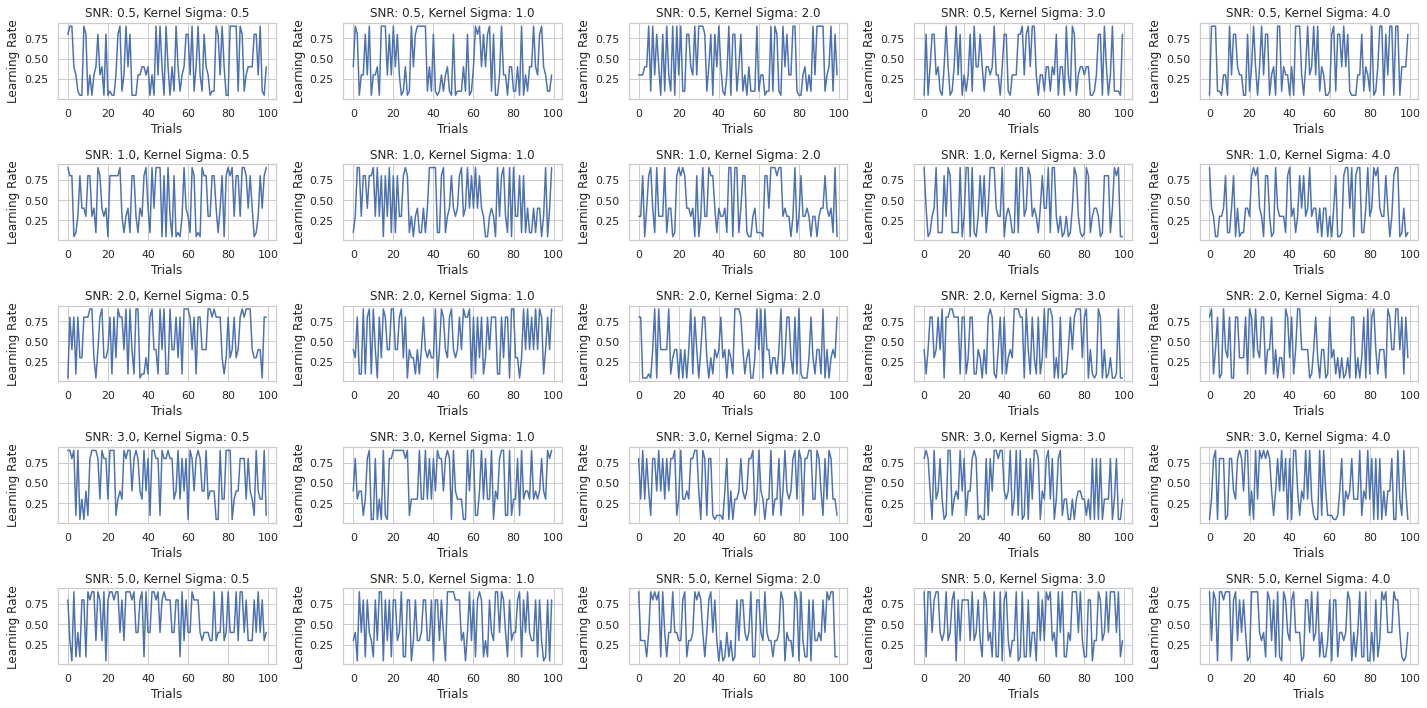

In [7]:
# set up variables;
unique_snr_values = data["snr"].unique()
unique_kernel_sigma_values = data["kernel_sigma"].unique()
unique_learning_rate_values = data["learning_rate"].unique()
unique_temperature_values = data["temperature"].unique()

# Generate combinations of snr and kernel_sigma
snr_kernel_combinations = list(itertools.product(
    unique_snr_values,
    unique_kernel_sigma_values
))

# Generate all combinations of snr, kernel_sigma, lr, and temp
lr_temp_combinations = list(itertools.product(
    unique_learning_rate_values,
    unique_temperature_values
))

num_rows = len(unique_snr_values)
num_cols = len(unique_kernel_sigma_values)
row_idx = 0
col_idx = 0

n_epochs = 100
epoch_length = list(range(0, n_epochs))
fig2, axs2 = plt.subplots(num_rows, num_cols, figsize=(20, 10))

# loop through all combinations;
for idx, (snr, kernel_sigma) in enumerate(snr_kernel_combinations):
    # vars to save trials data;
    trial_summary = []
    trial_best_lr = []
    trial_lr_summary = []

    # get data for current parameters;
    sub_data = data[(data['snr'] == snr) & (data['kernel_sigma'] == kernel_sigma)]

    # generate subplot data;
    for epoch in epoch_length:
        trial_data = sub_data[sub_data["epochs"] == epoch]
        trial_summary.append(np.mean(trial_data["reward"]))
        trial_lr_summary.append(np.mean(trial_data["learning_rate"]))

        # get only data with best learning_rate;
        best_learning_rate = trial_data.loc[trial_data["reward"].idxmax(), ["learning_rate"]]
        trial_data = trial_data[trial_data["learning_rate"] == best_learning_rate[0]]
        trial_best_lr.append(best_learning_rate)

    # apply median smoothing to trial_summary using a rolling window;
    window_size = 2
    smoothed_summary = np.convolve(trial_summary, np.ones(window_size)/window_size, mode='same')

    # Fig2. Plot learning rate with the smoothed line; 
    axs2[row_idx, col_idx].plot(epoch_length, trial_best_lr, label='Best LR')

    axs2[row_idx, col_idx].set_xlabel("Trials")
    axs2[row_idx, col_idx].set_ylabel("Learning Rate")
    axs2[row_idx, col_idx].set_title(f"SNR: {snr}, Kernel Sigma: {kernel_sigma}")

    # correctly index subplots
    col_idx += 1
    if col_idx == num_cols:
        row_idx += 1
        col_idx = 0

# adjust layout;
plt.tight_layout()
plt.show()

## Check best Models:

In [5]:
# set up variables;
unique_snr_values = data["snr"].unique()
unique_kernel_sigma_values = data["kernel_sigma"].unique()
unique_learning_rate_values = data["learning_rate"].unique()
unique_temperature_values = data["temperature"].unique()

# Generate combinations of snr and kernel_sigma
snr_kernel_combinations = list(itertools.product(
    unique_snr_values,
    unique_kernel_sigma_values
))

# Generate all combinations of snr, kernel_sigma, lr, and temp
lr_temp_combinations = list(itertools.product(
    unique_learning_rate_values,
    unique_temperature_values
))

best_models = []

for snr, (lr, temp) in zip(unique_snr_values, lr_temp_combinations):
    sub_data = data[data["snr"] == snr]
    sub_data = data[(data['learning_rate'] == lr) & (data['temperature'] == temp)]

    # get best lr and temperature for the current set of parameters;
    best_lr, best_temp = sub_data.loc[sub_data["optimum"].idxmax(), ["learning_rate", "temperature"]]
    best_models.append([snr, kernel_sigma, best_lr, best_temp])

# print best models;
best_models = pd.DataFrame(best_models, columns=["snr", "kernel_sigma", "best_lr", "best_temp"])

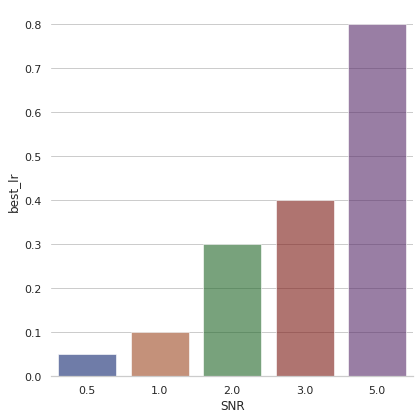

In [6]:
import seaborn as sns
sns.set_theme(style="whitegrid")

# Draw a nested barplot by species and sex
g = sns.catplot(
    data=best_models, kind="bar",
    x="snr", y="best_lr", hue=None,
    errorbar=None, palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("SNR", "best_lr")

In [8]:
best_models # best learning rate: (SNR * temp) * 0.8

,snr,kernel_sigma,best_lr,best_temp
0,0.5,4.0,0.05,0.2
1,1.0,4.0,0.10,0.2
2,2.0,4.0,0.30,0.2
3,3.0,4.0,0.40,0.2
4,5.0,4.0,0.80,0.2


In [11]:
# SNR = np.mean(reward) * np.std(reward) from real data
# reward plot with best learning rate and temp
# Q-val in optimal position instead of reward
# Q-table initialized as 0.5
# sigma >= q_table_size / n_trials

### Test softmax behavior

(0.0, 1.0)

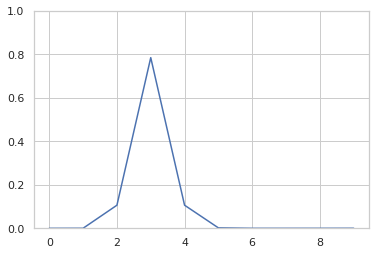

In [12]:
import numpy as np
from scipy.special import softmax
import matplotlib.pyplot as plt

alpha=0.1
temp = 0.1
dummy = np.array([0.05,0.2,0.8,1,0.8,0.4,-0.1,0,0.1,0.2])*10*alpha
sm = softmax(dummy / temp)
plt.plot(sm / np.sum(sm))
plt.ylim(0,1)


### Analyse first participant

In [1]:
import os
os.chdir("/home/giuseppe/PNI/Bkup/Projects/RL_sim/")
from agents.utils import create_bins, discretize_observation
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import numpy as np
import pandas as pd
import json
import ast

def read_json_log(log):
    with open(log, "rb") as f:
        log = json.load(f)
    return log
    
def json_array_to_list(arr):
    return ast.literal_eval(arr)


def score_datapoints(arr):
    mu = np.mean(arr)
    sigma = np.std(arr)
    return np.abs(arr - mu) < sigma

def calculate_snr(log):
    if isinstance(log, str):
        log = read_json_log(log)
    reward = np.array(json_array_to_list(log[-1]["reward"]))
    return reward.mean() / reward.std()

def plot_reward(log):
    log = read_json_log(log)
    reward = json_array_to_list(log[-1]["reward"])
    size = range(len(reward))
    snr = np.float16(calculate_snr(log))
    df = pd.DataFrame(columns=["trial", "reward"])
    df["trial"] = size
    df["reward"] = reward

    df = df[score_datapoints(df["reward"])]
    plt.figure(figsize=(10, 4))
    sns.regplot(x="trial", y="reward", data=df)
    plt.xlabel("Trials", fontsize=16)
    plt.ylabel("Reward", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title(f"SNR: {snr}, Kernel Sigma: 4.0", fontsize=20)
    plt.show()

def get_q_table_max(log, table_size):
    maxima = []
    for table in log:
        q_table = json_array_to_list(table["q_table"])
        maxima.append(np.unravel_index(np.argmax(q_table), table_size))
    return maxima

def get_q_table_steps(log, num_bins):
    steps = []
    for data in log:
        contrast = data["contrast"]
        frequency = data["frequency"]
        bins = create_bins(num_bins)
        steps.append(discretize_observation([contrast, frequency], bins))
    return steps

def plot_q_table_steps(log, session):
    log = read_json_log(log)
    last_table = np.array(json_array_to_list(log[-1]["q_table"])).reshape(10, 10)
    maxima = np.array(get_q_table_steps(log, 10)) + 1 # adjust discretization;
    steps = np.random.randint(0, len(maxima), len(maxima))

    plt.imshow(last_table)
    plt.xlabel("Frequency", fontsize=16)
    plt.ylabel("Contrast", fontsize=16)
    plt.colorbar().set_label("Q-value", fontsize=16)
    plt.plot(maxima[:, 1], maxima[:, 0], "--", alpha=0.4)
    plt.scatter(maxima[:, 1], maxima[:, 0], c=steps, cmap='plasma', alpha=0.5)
    plt.colorbar().set_label("Trial number", fontsize=16)
    plt.title(f"Real-time fMRI - Session {session}", fontsize=20)
    plt.show()


### Plot reward

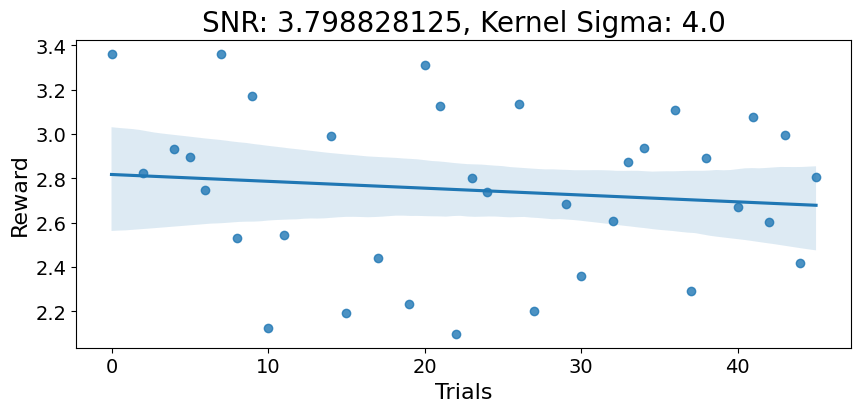

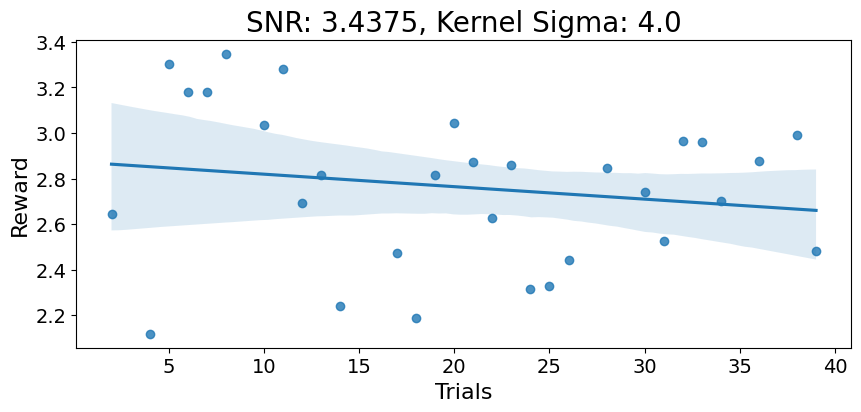

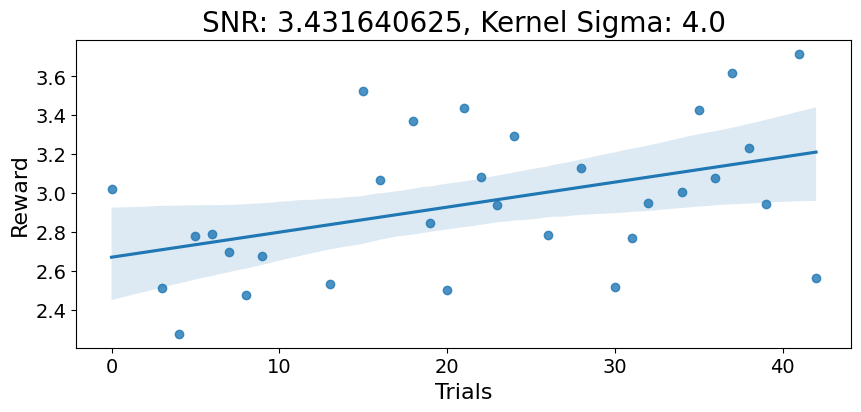

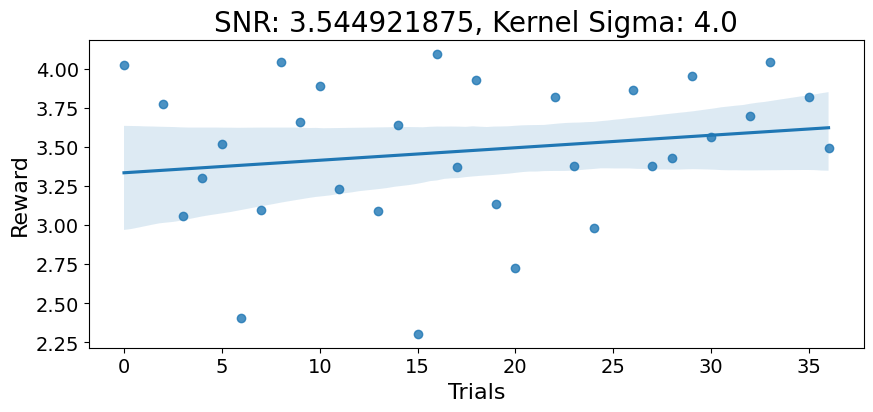

In [32]:
for sub in ["sub-001", "sub-002"]:
    logs = [
        f"/home/giuseppe/PNI/Bkup/Projects/RL_sim/data/{sub}/data_1/log/log.json",
        f"/home/giuseppe/PNI/Bkup/Projects/RL_sim/data/{sub}/data_2/log/log.json"
    ]

    for log in logs:
        plot_reward(log)

### Visualize Q-Table

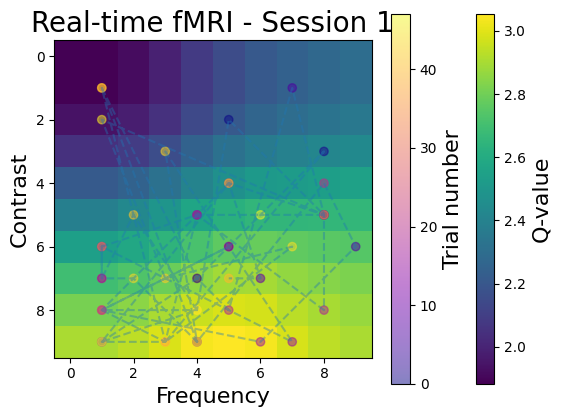

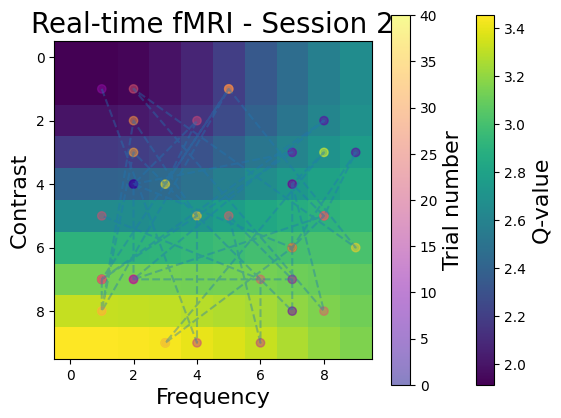

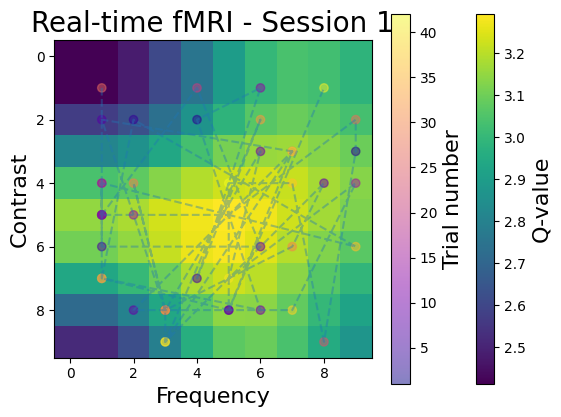

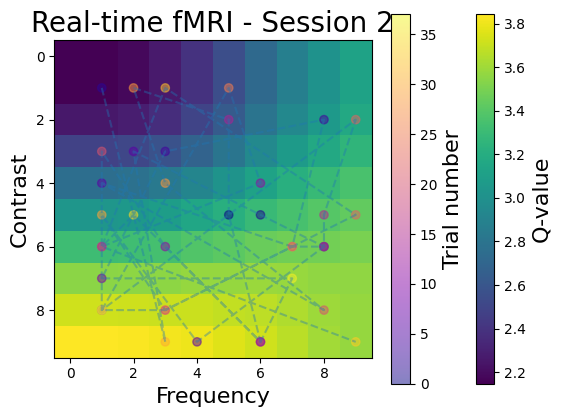

In [31]:
for sub in ["sub-001", "sub-002"]:
    logs = [
        f"/home/giuseppe/PNI/Bkup/Projects/RL_sim/data/{sub}/data_1/log/log.json",
        f"/home/giuseppe/PNI/Bkup/Projects/RL_sim/data/{sub}/data_2/log/log.json"
    ]

    for idx, log in enumerate(logs):
        plot_q_table_steps(log, idx + 1)

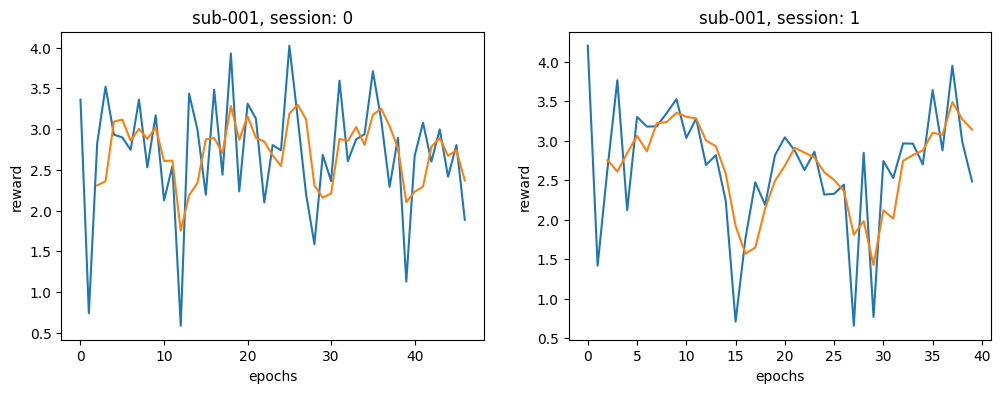

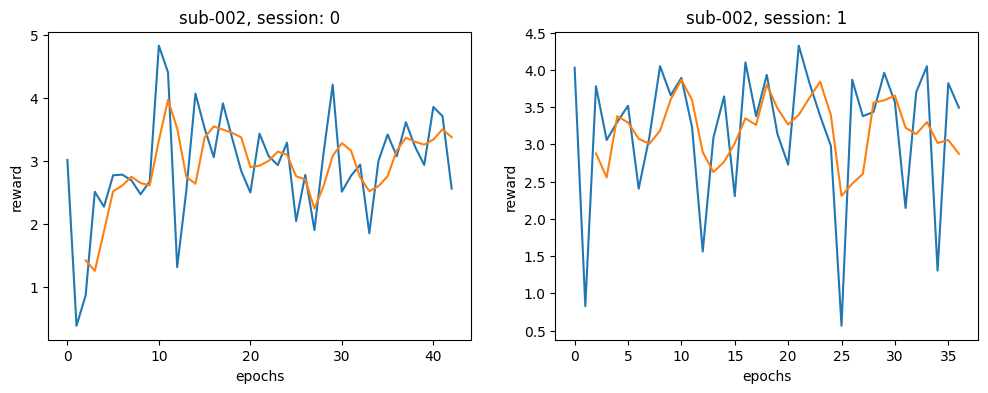

In [29]:
for sub in ["sub-001", "sub-002"]:
    logs = [
        f"/home/giuseppe/PNI/Bkup/Projects/RL_sim/data/{sub}/data_1/log/log.json",
        f"/home/giuseppe/PNI/Bkup/Projects/RL_sim/data/{sub}/data_2/log/log.json"
    ]

    n_plot = 0
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    for log in logs:

        log = read_json_log(log)
        reward = json_array_to_list(log[-1]["reward"])
        rolling_mean = pd.Series(reward).rolling(window=3).mean()

        # plot reward;
        axs[n_plot].set_title(f"{sub}, session: {n_plot}")
        axs[n_plot].plot(reward)
        axs[n_plot].plot(rolling_mean.to_numpy())
        axs[n_plot].set_xlabel("epochs")
        axs[n_plot].set_ylabel("reward")
        n_plot += 1

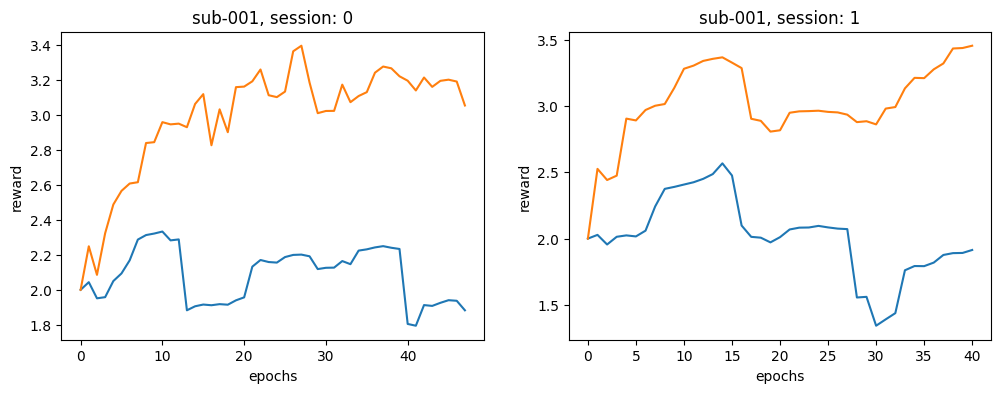

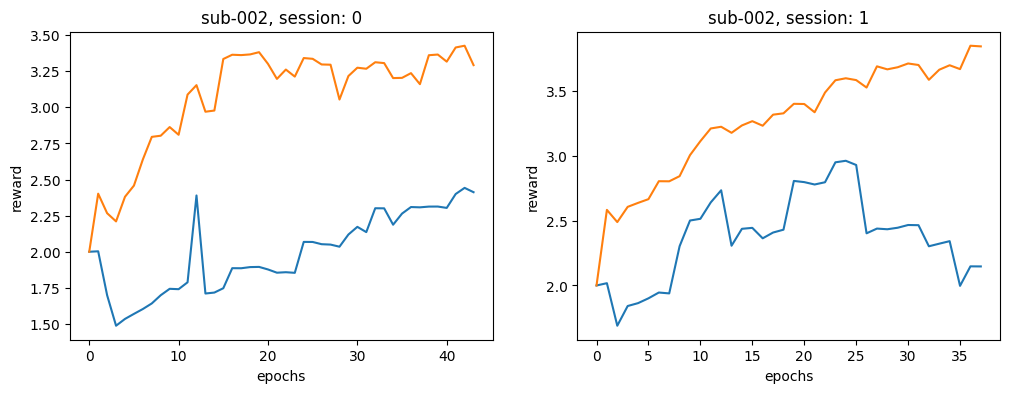

In [30]:
for sub in ["sub-001", "sub-002"]:
    logs = [
        f"/home/giuseppe/PNI/Bkup/Projects/RL_sim/data/{sub}/data_1/log/log.json",
        f"/home/giuseppe/PNI/Bkup/Projects/RL_sim/data/{sub}/data_2/log/log.json"
    ]

    n_plot = 0
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    for log in logs:
        log = read_json_log(log)
        max_val = []
        min_val = []

        for idx in range(len(log)):
            table = np.array(json_array_to_list(log[idx]["q_table"]))
            min_val.append(np.min(table))
            max_val.append(np.max(table))


        # plot reward;
        axs[n_plot].set_title(f"{sub}, session: {n_plot}")
        axs[n_plot].plot(min_val)
        axs[n_plot].plot(max_val)
        axs[n_plot].set_xlabel("epochs")
        axs[n_plot].set_ylabel("reward")
        n_plot += 1

In [52]:
log = read_json_log("/home/giuseppe/PNI/Bkup/Projects/RL_sim/data/sub-001/data_1/log/log.json")
contrast = []
frequency = []
reward_log = []

for idx in range(len(log)):
    contrast.append(json_array_to_list(log[idx]["last action"])[0])
    frequency.append(json_array_to_list(log[idx]["last action"])[1])

reward = json_array_to_list(log[-1]["reward"])
reward.insert(0, 0)

data = pd.DataFrame({
    'Contrast': contrast,
    'Frequency': frequency,
    'Reward': reward
})

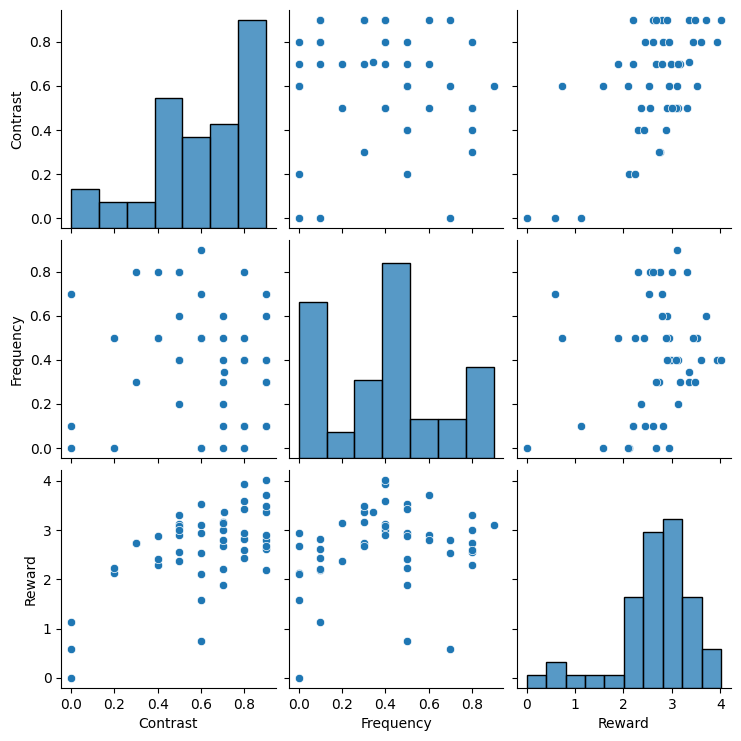

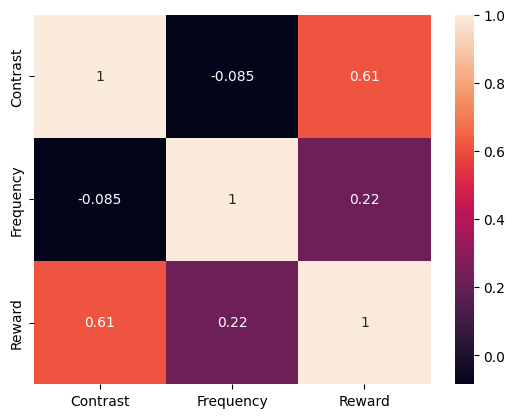

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pairplot to visualize relationships
sns.pairplot(data)
plt.show()

# Correlation matrix
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()